In [62]:
import pandas as pd
import torch
import string
import numpy as np
import re
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [85]:
# Function to clean words by removing special characters
def clean_word(word):
    # Remove anything that's not a letter (a-z) or dot (.), and convert to lowercase
    return re.sub(r'[^a-z]', '', word.lower())

# Load the dataset
data = pd.read_csv('pokemon.csv')["name"]
words = data.to_list()
words = list(map(clean_word, words))

In [86]:
len(words)

801

In [72]:
words[:8]

['bulbasaur',
 'ivysaur',
 'venusaur',
 'charmander',
 'charmeleon',
 'charizard',
 'squirtle',
 'wartortle']

In [87]:
#build the vocabulary
chars = sorted(list(set(' '.join(words))))
print(chars)
print("###")
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
print(stoi)
print("###")
print(itos)

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
###
{' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, '.': 0}
###
{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}


In [79]:
block_size = 3 
for w in words[:2]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]  

bulbasaur
... ---> b
..b ---> u
.bu ---> l
bul ---> b
ulb ---> a
lba ---> s
bas ---> a
asa ---> u
sau ---> r
aur ---> .
ivysaur
... ---> i
..i ---> v
.iv ---> y
ivy ---> s
vys ---> a
ysa ---> u
sau ---> r
aur ---> .


In [80]:
# build the training and test splits
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([5384, 3]) torch.Size([5384])
torch.Size([686, 3]) torch.Size([686])
torch.Size([690, 3]) torch.Size([690])


In [7]:
Xtr.shape, Ytr.shape

(torch.Size([5384, 3]), torch.Size([5384]))

In [8]:
C = torch.randn((27, 2))

In [9]:
Xtr = torch.clamp(Xtr, max=C.size(0) - 1)
Ytr = torch.clamp(Ytr, max=C.size(0) - 1)
Xdev = torch.clamp(Xdev, max=C.size(0) - 1)
Ydev = torch.clamp(Ydev, max=C.size(0) - 1)
Xtr.shape, Ytr.shape

(torch.Size([5384, 3]), torch.Size([5384]))

In [47]:
g = torch.Generator()
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [48]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [49]:
for p in parameters:
  p.requires_grad = True
lri=[]
lossi = []
stepi= []

In [50]:
#minibatch for optimisation and learning rates

for i in range(100000):
    ix = torch.randint(0,Xtr.shape[0], (32,))
    
    #forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    #backward pass
    for p in parameters:
      p.grad = None
    loss.backward()
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    stepi.append(i)
    #lri.append(lre[i])
    lossi.append(loss.log10().item())

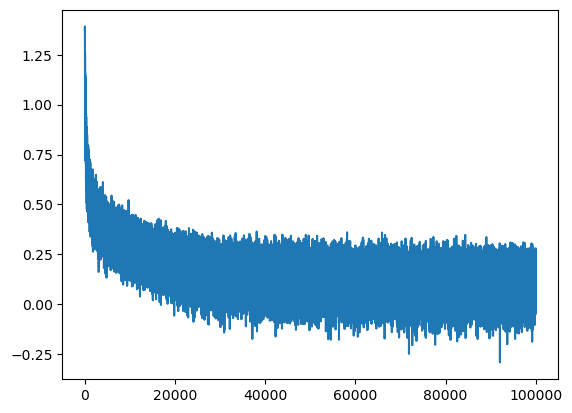

In [52]:
plt.plot(stepi,lossi)

In [53]:
print(loss.item())

1.4478713274002075


In [54]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [31]:
g = torch.Generator().manual_seed(10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

simikyu.
dwebble.
baltarill.
pupi.
don.
burr.
spirith.
sola.
patran.
met.
meow.
omank.
wormantis.
bune.
glisa.
whirlix.
hydol.
audinja.
digler.
skipedenneon.


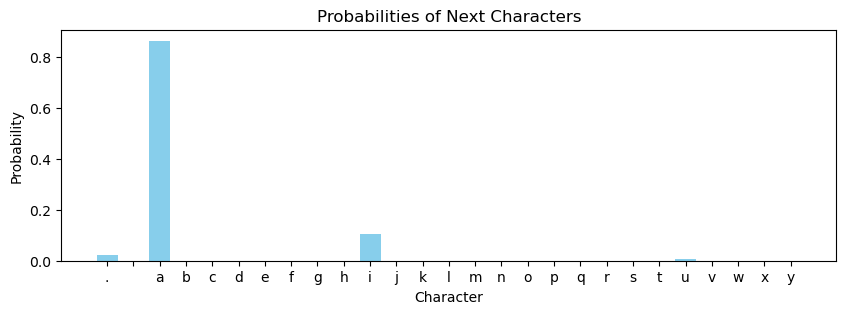

In [60]:
input_chars = "pik"  # Example input to get probabilities of next characters

# Convert input characters to indices based on stoi (character-to-index mapping)
context = [stoi.get(char, 0) for char in input_chars][-block_size:]  # Ensure context fits block size
context = [0] * (block_size - len(context)) + context  # Pad if shorter than block size

# Embedding the current context
emb = C[torch.tensor([context])]

# Pass through the network layers
h = torch.tanh(emb.view(1, -1) @ W1 + b1)
logits = h @ W2 + b2

# Compute the probabilities
probs = F.softmax(logits, dim=1).squeeze()  # Squeeze to remove unnecessary dimensions

# Print out the probabilities for each character
next_char_probs = {itos[i]: probs[i].item() for i in range(len(probs))}

# Display probabilities
chars = list(next_char_probs.keys())  # List of characters
probs = list(next_char_probs.values())  # List of their corresponding probabilities

# Create a bar chart
plt.figure(figsize=(10, 3))
plt.bar(chars, probs, color='skyblue')
plt.xlabel('Character')
plt.ylabel('Probability')
plt.title('Probabilities of Next Characters')
plt.xticks()  # Rotate characters on x-axis for better readability
plt.show()


In [43]:
#saving the model to be used in the streamlit app
variables_to_save = {
    "C": C,
    "W1": W1,
    "b1": b1,
    "W2": W2,
    "b2": b2,
    "block_size": block_size,
    "stoi": stoi,
    "itos": itos
}

# Save all variables to a file
torch.save(variables_to_save, "model_parameters.pth")